# Spread Option Pricing: Modified Kirk Engine

This notebook demonstrates the `ModifiedKirkEngine` from `pyquantlib.extensions`, a pure Python pricing engine that improves upon Kirk's approximation for spread options.

## Background

A **spread option** pays the difference between two asset prices at maturity. For a European call with strike $K$:

$$V = e^{-rT}\,\mathbb{E}\!\left[\max(S_1(T) - S_2(T) - K,\; 0)\right]$$

where $S_1$ and $S_2$ follow correlated geometric Brownian motions:

$$\frac{dS_i}{S_i} = (r - q_i)\,dt + \sigma_i\,dW_i, \qquad dW_1\,dW_2 = \rho\,dt$$

### Kirk's Approximation (1995)

Kirk reduces the two-asset problem to a single Black-Scholes call with an effective forward $F_1$ and effective strike $K_{\text{eff}} = F_2 + K$, using an adjusted volatility:

$$\sigma_K = \sqrt{\sigma_1^2 - 2\rho\,\sigma_1\sigma_2 w + (\sigma_2 w)^2}, \qquad w = \frac{F_2}{F_2 + K}$$

This works well for moderate correlations but becomes inaccurate when $\rho \to 1$ or $K$ is large.

### Modified Kirk Approximation (Alos & Leon, 2015)

The modification adds a **volatility skew correction** derived using Malliavin calculus. The corrected volatility is:

$$\sigma_{\text{MK}}(x) = \sigma_K + \beta\,\bigl(\ln F_1 - \ln K_{\text{eff}}\bigr)$$

where the skew slope $\beta$ is:

$$\beta = \frac{1}{2}\,\frac{(\sigma_2 w - \rho\,\sigma_1)^2 \;\cdot\; \sigma_2^2\,F_2\,K}{(F_2 + K)^2 \;\cdot\; \sigma_K^3}$$

This correction captures the implied volatility skew around the effective strike, significantly improving accuracy for high-correlation cases.

### References
1. Kirk, E. (1995). "Correlation in the energy markets." *Managing Energy Price Risk*.
2. Alos, E., & Leon, J.A. (2015). *Quantitative Finance*, 16(1), 31-42.
3. Harutyunyan & Masip Borras (2018). arXiv:1812.04272 (numerical analysis)

In [91]:
import pyquantlib as ql
from pyquantlib.extensions import ModifiedKirkEngine
import numpy as np
import matplotlib.pyplot as plt

print(f"PyQuantLib version: {ql.__version__}")
print(f"QuantLib version: {ql.QL_VERSION}")

PyQuantLib version: 0.2.0.dev0
QuantLib version: 1.40


## 1. Market Setup

Both assets follow GBM with $r = q_1 = q_2 = 0$ (so $F_i = S_i$), matching the paper parameters from [3].

In [92]:
# Set evaluation date
today = ql.Date(15, 1, 2025)
ql.Settings.instance().evaluationDate = today

# Common parameters
dc = ql.Actual365Fixed()
cal = ql.NullCalendar()

# Zero interest rate (as in the paper)
rate_ts = ql.FlatForward(today, 0.0, dc)
rate_handle = ql.YieldTermStructureHandle(rate_ts)

# No dividends
div_ts = ql.FlatForward(today, 0.0, dc)
div_handle = ql.YieldTermStructureHandle(div_ts)

def make_process(spot, vol):
    """Create a Black-Scholes process."""
    spot_h = ql.QuoteHandle(ql.SimpleQuote(spot))
    vol_ts = ql.BlackConstantVol(today, cal, vol, dc)
    vol_h = ql.BlackVolTermStructureHandle(vol_ts)
    return ql.GeneralizedBlackScholesProcess(spot_h, div_handle, rate_handle, vol_h)

def make_option(K, T_years):
    """Create a spread call option."""
    maturity = today + ql.Period(int(T_years * 365), ql.Days)
    payoff = ql.PlainVanillaPayoff(ql.OptionType.Call, K)
    spread_payoff = ql.SpreadBasketPayoff(payoff)
    exercise = ql.EuropeanExercise(maturity)
    return ql.BasketOption(spread_payoff, exercise)

## 2. Basic Spread Option Pricing

Pricing a spread call with payoff $\max(S_1 - S_2 - K,\; 0)$.

Kirk maps this to a Black call on $F_1$ with strike $K_{\text{eff}} = F_2 + K$ and volatility $\sigma_K$. The Modified Kirk then adjusts:

$$\sigma_{\text{MK}} = \sigma_K + \beta\,\bigl(\ln F_1 - \ln K_{\text{eff}}\bigr)$$

In [93]:
# Paper parameters
S1, S2 = 100.0, 100.0
sigma1, sigma2 = 0.30, 0.20
K = 5.0
T = 0.5
rho = 0.90

# Create processes
process1 = make_process(S1, sigma1)
process2 = make_process(S2, sigma2)

# Create spread option
option = make_option(K, T)

# Price with standard Kirk
kirk_engine = ql.KirkEngine(process1, process2, rho)
option.setPricingEngine(kirk_engine)
kirk_price = option.NPV()

# Price with Modified Kirk
mod_kirk_engine = ModifiedKirkEngine(process1, process2, rho)
option.setPricingEngine(mod_kirk_engine)
mod_kirk_price = option.NPV()

print(f"Spread Option: S1={S1}, S2={S2}, K={K}, T={T}y, rho={rho}")
print(f"sigma1={sigma1:.0%}, sigma2={sigma2:.0%}")
print(f"")
print(f"Kirk Price:          {kirk_price:.6f}")
print(f"Modified Kirk Price: {mod_kirk_price:.6f}")

Spread Option: S1=100.0, S2=100.0, K=5.0, T=0.5y, rho=0.9
sigma1=30%, sigma2=20%

Kirk Price:          2.359253
Modified Kirk Price: 2.357221


---

## 3. Reproducing Results from [3]

The paper shows how Kirk's error grows exponentially with $\rho$ and $K$, while Modified Kirk remains stable.

**Paper parameters:** $S_1 = S_2 = 100$, $\sigma_1 = 0.30$, $\sigma_2 = 0.20$, $T = 0.5$, $r = 0$, $K \in [0, 20]$, $\rho \in \{0.80,\; 0.85,\; 0.90,\; 0.95,\; 0.999\}$.

In [94]:
def price_spread(S1, S2, sigma1, sigma2, K, T, rho, method='kirk'):
    """Price a spread option using various methods."""
    process1 = make_process(S1, sigma1)
    process2 = make_process(S2, sigma2)
    option = make_option(K, T)
    
    if method == 'kirk':
        engine = ql.KirkEngine(process1, process2, rho)
    elif method == 'modified_kirk':
        engine = ModifiedKirkEngine(process1, process2, rho)
    elif method == 'mc':
        corr = ql.Matrix(2, 2)
        corr[0][0] = corr[1][1] = 1.0
        corr[0][1] = corr[1][0] = rho
        proc_array = ql.StochasticProcessArray([process1, process2], corr)
        # Use high sample count for accuracy (paper used 5M with antithetic)
        engine = ql.MCEuropeanBasketEngine(
            proc_array, timeSteps=1, requiredSamples=500000, seed=42
        )
    else:
        raise ValueError(f"Unknown method: {method}")
    
    option.setPricingEngine(engine)
    return option.NPV()

# Fixed parameters from paper
S1, S2 = 100.0, 100.0
sigma1, sigma2 = 0.30, 0.20
T = 0.5

# Strike range: 0 to 20
K_values = list(range(0, 21))

# Correlation values for Figures 1-5
rho_values = [0.80, 0.85, 0.90, 0.95, 0.999]

print("Computing prices for Figures 1-5 reproduction...")
print(f"Parameters: S1=S2={S1}, sigma1={sigma1}, sigma2={sigma2}, T={T}")
print(f"Strike range: K = {K_values[0]} to {K_values[-1]}")
print(f"Correlation values: rho = {rho_values}")

Computing prices for Figures 1-5 reproduction...
Parameters: S1=S2=100.0, sigma1=0.3, sigma2=0.2, T=0.5
Strike range: K = 0 to 20
Correlation values: rho = [0.8, 0.85, 0.9, 0.95, 0.999]


In [ ]:
# Compute all prices
results = {}

for rho in rho_values:
    print(f"\nComputing rho = {rho}...")
    kirk_prices = []
    mod_kirk_prices = []
    mc_prices = []
    
    for K in K_values:
        # Handle K=0 case (Margrabe)
        K_adj = max(K, 0.001)  # Small epsilon to avoid division issues
        
        kirk = price_spread(S1, S2, sigma1, sigma2, K_adj, T, rho, 'kirk')
        mod_kirk = price_spread(S1, S2, sigma1, sigma2, K_adj, T, rho, 'modified_kirk')
        mc = price_spread(S1, S2, sigma1, sigma2, K_adj, T, rho, 'mc')
        
        kirk_prices.append(kirk)
        mod_kirk_prices.append(mod_kirk)
        mc_prices.append(mc)
    
    # Compute errors (% relative to MC)
    kirk_errors = [(k - mc) / mc * 100 if mc > 0.001 else 0 
                   for k, mc in zip(kirk_prices, mc_prices)]
    mod_kirk_errors = [(mk - mc) / mc * 100 if mc > 0.001 else 0 
                       for mk, mc in zip(mod_kirk_prices, mc_prices)]
    
    results[rho] = {
        'kirk': kirk_prices,
        'mod_kirk': mod_kirk_prices,
        'mc': mc_prices,
        'kirk_error': kirk_errors,
        'mod_kirk_error': mod_kirk_errors
    }
    
    print(f"  Max Kirk error: {max(kirk_errors):.2f}%, Max Mod.Kirk error: {max(abs(e) for e in mod_kirk_errors):.2f}%")

print("\nAll computations complete.")


Computing rho = 0.8...
  Done. Max Kirk error: 1.02%, Max Mod.Kirk error: 0.28%

Computing rho = 0.85...
  Done. Max Kirk error: 1.88%, Max Mod.Kirk error: 0.32%

Computing rho = 0.9...
  Done. Max Kirk error: 3.60%, Max Mod.Kirk error: 0.30%

Computing rho = 0.95...
  Done. Max Kirk error: 7.48%, Max Mod.Kirk error: 0.29%

Computing rho = 0.999...
  Done. Max Kirk error: 20.08%, Max Mod.Kirk error: 0.72%

All computations complete!


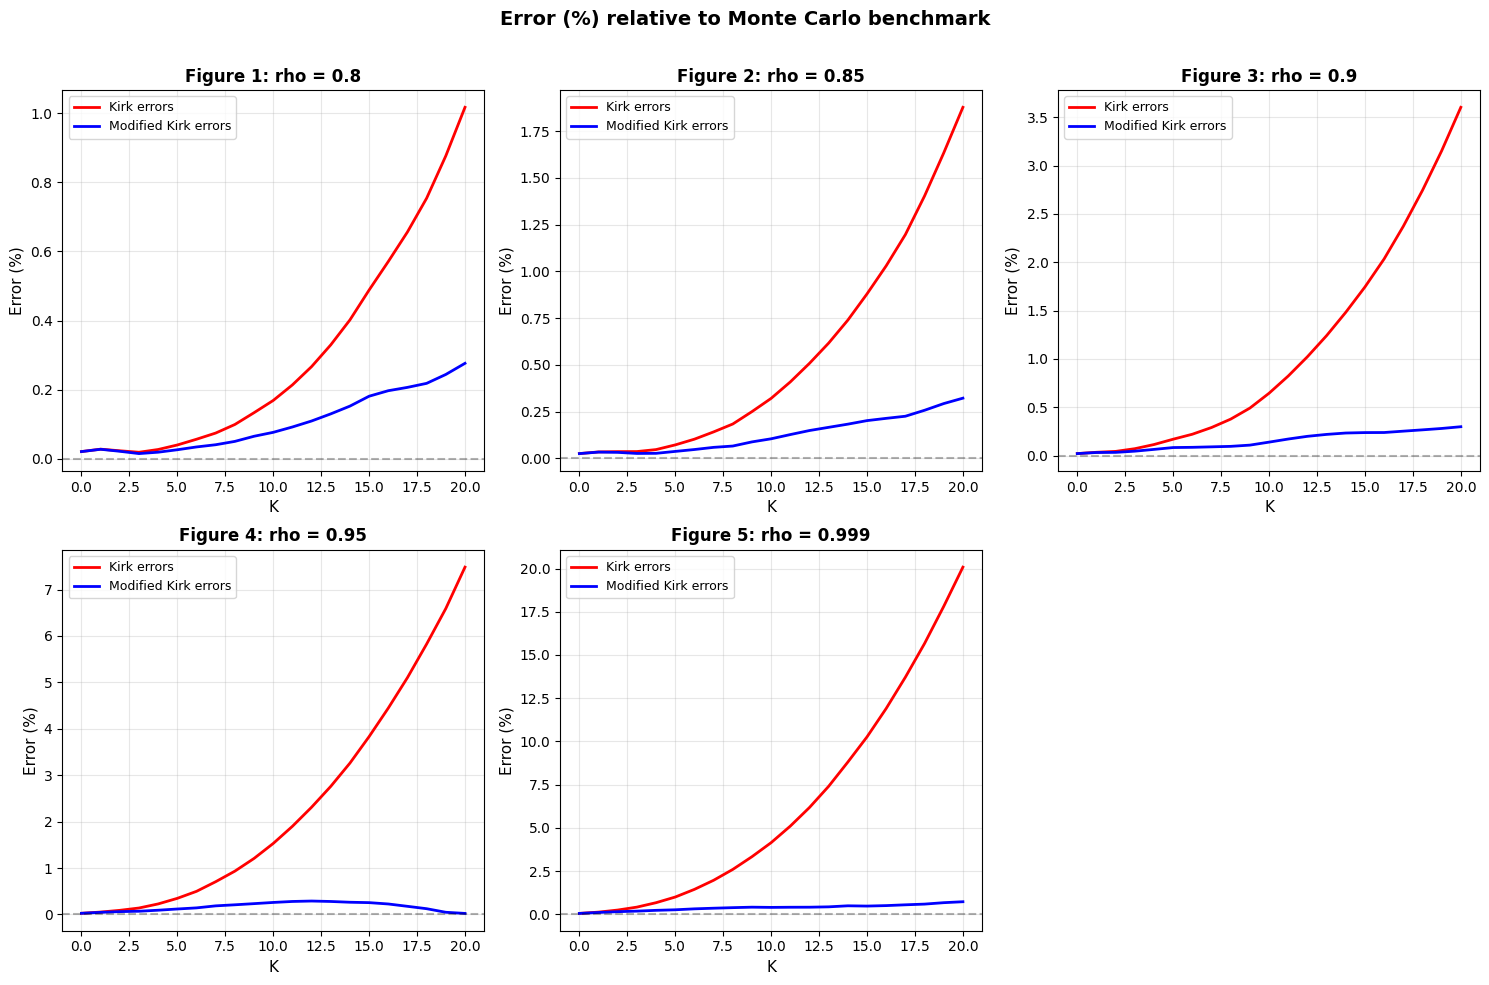

In [96]:
# Create Figures 1-5
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, rho in enumerate(rho_values):
    ax = axes[idx]
    
    kirk_err = results[rho]['kirk_error']
    mod_kirk_err = results[rho]['mod_kirk_error']
    
    ax.plot(K_values, kirk_err, 'r-', linewidth=2, label='Kirk errors')
    ax.plot(K_values, mod_kirk_err, 'b-', linewidth=2, label='Modified Kirk errors')
    
    ax.set_xlabel('K', fontsize=11)
    ax.set_ylabel('Error (%)', fontsize=11)
    ax.set_title(f'Figure {idx+1}: rho = {rho}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Hide the 6th subplot
axes[5].axis('off')

plt.suptitle('Error (%) relative to Monte Carlo benchmark', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## 4. Analysis

The figures above reproduce the key findings from the paper:

1. **Kirk's error grows exponentially** with both $\rho$ and $K$. As $\rho \to 1$, the weight $w \to F_2/(F_2+K)$ makes Kirk's flat-vol assumption increasingly wrong.

2. **Modified Kirk remains bounded** even at $\rho = 0.999$, because the skew correction $\beta$ captures precisely the curvature that Kirk misses.

3. **At low $\rho$**, both methods perform similarly since the skew slope $\beta \propto (\sigma_2 w - \rho\,\sigma_1)^2$ is small.

In [97]:
# Summary table: Maximum errors
print("Maximum Pricing Errors (%) vs Monte Carlo")
print("="*50)
print(f"{'rho':>8} {'Kirk Max Err':>15} {'Mod.Kirk Max Err':>18}")
print("-"*50)

for rho in rho_values:
    kirk_max = max(results[rho]['kirk_error'])
    mod_kirk_max = max(abs(e) for e in results[rho]['mod_kirk_error'])
    improvement = kirk_max / mod_kirk_max if mod_kirk_max > 0 else float('inf')
    print(f"{rho:>8.3f} {kirk_max:>14.2f}% {mod_kirk_max:>17.2f}%")

Maximum Pricing Errors (%) vs Monte Carlo
     rho    Kirk Max Err   Mod.Kirk Max Err
--------------------------------------------------
   0.800           1.02%              0.28%
   0.850           1.88%              0.32%
   0.900           3.60%              0.30%
   0.950           7.48%              0.29%
   0.999          20.08%              0.72%


In [98]:
# Error at specific K values
print("\nPricing Comparison at K=5 and K=10")
print("="*75)

for K_test in [5, 10]:
    print(f"\nK = {K_test}:")
    print(f"{'rho':>8} {'MC Price':>12} {'Kirk':>12} {'Mod.Kirk':>12} {'Kirk Err':>10} {'Mod.Err':>10}")
    print("-"*70)
    
    for rho in rho_values:
        idx = K_test  # K values are 0, 1, 2, ... so index = K
        mc = results[rho]['mc'][idx]
        kirk = results[rho]['kirk'][idx]
        mod_kirk = results[rho]['mod_kirk'][idx]
        kirk_err = results[rho]['kirk_error'][idx]
        mod_err = results[rho]['mod_kirk_error'][idx]
        
        print(f"{rho:>8.3f} {mc:>12.4f} {kirk:>12.4f} {mod_kirk:>12.4f} {kirk_err:>9.2f}% {mod_err:>9.2f}%")


Pricing Comparison at K=5 and K=10

K = 5:
     rho     MC Price         Kirk     Mod.Kirk   Kirk Err    Mod.Err
----------------------------------------------------------------------
   0.800       3.2496       3.2509       3.2505      0.04%      0.03%
   0.850       2.8215       2.8235       2.8225      0.07%      0.04%
   0.900       2.3552       2.3593       2.3572      0.17%      0.08%
   0.950       1.8407       1.8471       1.8429      0.35%      0.12%
   0.999       1.2700       1.2827       1.2733      1.00%      0.26%

K = 10:
     rho     MC Price         Kirk     Mod.Kirk   Kirk Err    Mod.Err
----------------------------------------------------------------------
   0.800       1.9506       1.9539       1.9521      0.17%      0.08%
   0.850       1.6129       1.6181       1.6146      0.32%      0.10%
   0.900       1.2620       1.2701       1.2637      0.65%      0.14%
   0.950       0.8983       0.9120       0.9006      1.53%      0.26%
   0.999       0.5368       0.5591 